In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers, regularizers

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [20]:
from sklearn.model_selection import train_test_split, KFold, cross_validate, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import roc_curve, auc

In [21]:
data = pd.read_csv('hotel_bookings.csv')
data_cln = data.fillna({'children': 0.0, 'country': 'Unknown', 'agent':0, 'company': 0})
data_cln['meal'].replace('Undefined', 'SC', inplace = True)

num_features = ["lead_time","arrival_date_week_number","arrival_date_day_of_month",
                "stays_in_weekend_nights","stays_in_week_nights","adults","children",
                "babies","is_repeated_guest", "previous_cancellations",
                "previous_bookings_not_canceled","agent","company",
                "required_car_parking_spaces", "total_of_special_requests", "adr"]

cat_features = ["arrival_date_month","meal","market_segment",
                "distribution_channel","reserved_room_type","deposit_type","customer_type"]

# Separate features and predicted value
features = num_features + cat_features

# preprocess numerical feats:
# for most num cols, except the dates, 0 is the most logical choice as fill value
# and here no dates are missing.
num_transformer = SimpleImputer(strategy="constant")

# Preprocessing for categorical features:
cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="Unknown")),
    ("onehot", OneHotEncoder(handle_unknown='ignore'))])

# Bundle preprocessing for numerical and categorical features:
preprocessor = ColumnTransformer(transformers=[("num", num_transformer, num_features),
                                               ("cat", cat_transformer, cat_features)])



In [22]:
resort_data = data_cln[data_cln.hotel == 'Resort Hotel']
city_data = data_cln[data_cln.hotel == 'City Hotel']

In [23]:
def test_model_1():
    inputs = keras.Input(shape=(62, 1,), dtype = "float32")
    x = layers.Bidirectional(layers.LSTM(256, return_sequences = True))(inputs)
    #x = layers.Bidirectional(layers.LSTM(128, return_sequences = True))(x)
    x = layers.Bidirectional(layers.LSTM(128, return_sequences = True))(x)
    x = layers.Flatten()(x)
    # outputs = layers.Reshape((100, 256, 1))(x)
    outputs = layers.Dense(1, activation='sigmoid',
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(x)
    model = keras.Model(inputs, outputs)
    # model.summary()

    model.compile("adam", "binary_crossentropy", metrics=["accuracy", "AUC"])
    return model

In [24]:
tmp = test_model_1()

Model: "functional_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 62, 1)]           0         
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 62, 512)           528384    
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 62, 256)           656384    
_________________________________________________________________
flatten_1 (Flatten)          (None, 15872)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 15873     
Total params: 1,200,641
Trainable params: 1,200,641
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# 10 fold
kfolds = 10 # 
split = KFold(n_splits=kfolds, shuffle=True, random_state=42)

X = data_cln.drop(["is_canceled"], axis=1)[features]
y = data_cln["is_canceled"].to_numpy()

X = preprocessor.fit_transform(X)
X = X.reshape((-1, 62, 1))
result = []

for train_index, test_index in split.split(y):
    train_x = X[train_index]
    train_y = y[train_index]
    
    test_x = X[test_index]
    test_y = y[test_index]
    
    model = test_model_1()
    
    history = model.fit(train_x, train_y, batch_size=64, epochs=30, verbose = 2)
    pred_y = model.predict(test_x)
    result.append({'pred': pred_y, 'test': test_y})

Model: "functional_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 62, 1)]           0         
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 62, 512)           528384    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 62, 256)           656384    
_________________________________________________________________
flatten_2 (Flatten)          (None, 15872)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 15873     
Total params: 1,200,641
Trainable params: 1,200,641
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
1679/1679 - 57s - loss: 0.4511 - accuracy: 0.7919 - auc: 0.8384
Epoch 2/30
1679/1679 - 56s - loss:

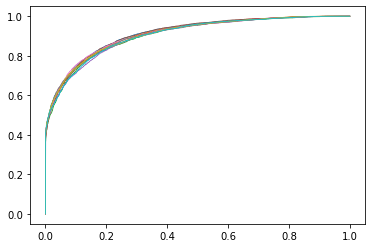

In [26]:
total_accuracy = []
total_f1 = []
total_pre = []
total_recall = []
total_auc = []
for i in range(10):
    pred = result[i]['pred']
    test = result[i]['test']
    fpr, tpr, _ = roc_curve(test, pred)
    roc_auc = auc(fpr, tpr)
    total_auc.append(roc_auc)
    plt.plot(fpr, tpr, lw=0.8)
    t_acc = []
    t_f1 = []
    t_pre = []
    t_rec = []
    for t in np.arange(0,1,0.05):
        p_val = np.zeros(pred.shape)
        p_val[pred > t] = 1
        t_acc.append(accuracy_score(test, p_val))
        t_f1.append(f1_score(test, p_val))
        t_pre.append(precision_score(test, p_val))
        t_rec.append(recall_score(test, p_val)) 
    total_accuracy.append(np.max(t_acc))
    total_f1.append(np.max(t_f1))
    total_pre.append(np.max(t_pre))
    total_recall.append(np.max(t_rec)) 
    
plt.savefig('totalEncodeDNN.png')

In [27]:
total_res = {'auc':total_auc, 'acc': total_accuracy, 'f1': total_f1,
            'pre': total_pre, 'recall': total_recall}

In [28]:
# total
for k, v in total_res.items():
    print(k, '\t', min(v), max(v), np.average(v))

auc 	 0.9043790063346595 0.9128506491700357 0.908482825674995
acc 	 0.8352458329843371 0.8448781304966915 0.8401289890275567
f1 	 0.7631318136769079 0.7863621462135285 0.7768689567526124
pre 	 0.9597254004576659 0.9884827240861291 0.9683224993588662
recall 	 1.0 1.0 1.0


In [29]:
total_res

{'auc': [0.9128506491700357,
  0.9109637028522913,
  0.9043790063346595,
  0.9086767441477281,
  0.904426561945727,
  0.9123656788928638,
  0.9096808176397294,
  0.9079073054758486,
  0.9084937878784873,
  0.9050840024125815],
 'acc': [0.8411089706005528,
  0.8425328754502052,
  0.8375073289220203,
  0.8407739341653405,
  0.8352458329843371,
  0.8396850657509004,
  0.8448781304966915,
  0.8421978390149929,
  0.8413602479269621,
  0.8359996649635648],
 'f1': [0.7852306390181972,
  0.7836934729338383,
  0.7719257807998157,
  0.7763934426229507,
  0.7631318136769079,
  0.7826375816631601,
  0.7863621462135285,
  0.7738120834229198,
  0.7780661175674152,
  0.7674364896073904],
 'pre': [0.976513098464318,
  0.9666966696669667,
  0.9597254004576659,
  0.9653465346534653,
  0.9646139705882353,
  0.9612200435729847,
  0.962569119523607,
  0.9668310174809502,
  0.9884827240861291,
  0.9712264150943396],
 'recall': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}

In [13]:
np.average(total_res['auc'])

0.8015571755023224

In [14]:
np.average(total_res['acc'])

0.7918047928107839